In [1]:
#!pip install shap

In [2]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor,Pool
import matplotlib.patches as patch
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import skew
from scipy.stats import norm
from scipy import linalg
from sklearn import tree
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import warnings
import random
import eli5
import shap  # package used to calculate Shap values
import time
import glob
import sys
import os

In [3]:
from tqdm import tqdm 

In [4]:
os.chdir("D:\ISU\Big data\Project")

In [5]:
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

In [6]:
import pandas as pd
import random  

In [7]:

train = pd.read_csv("train.csv",nrows=200000)

In [8]:
train.describe()

,acoustic_data,time_to_failure
count,200000.00000000000000,200000.000000000000000
mean,4.83768500000000,1.443691339598257
std,5.73269597656886,0.014994579273506
min,-154.00000000000000,1.418096253100000
25%,2.00000000000000,1.430797185625000
50%,5.00000000000000,1.443598118150000
75%,7.00000000000000,1.456399050675000
max,181.00000000000000,1.469099983200000


Exploratory Data Analysis

Wall time: 416 ms


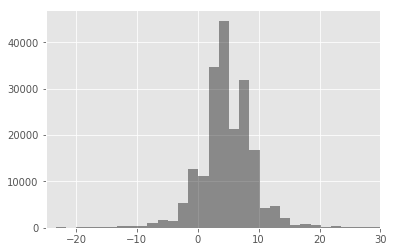

In [9]:
%%time
sns.distplot(train.acoustic_data.values, color="Black", bins=200, kde=False)
plt.xlim(-25, 30)

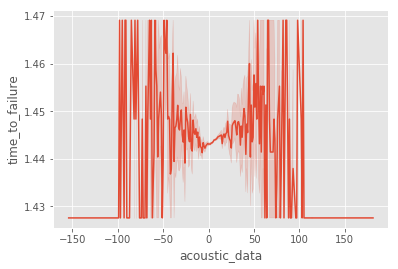

In [10]:
sns.lineplot(data=train, y="time_to_failure", x="acoustic_data")

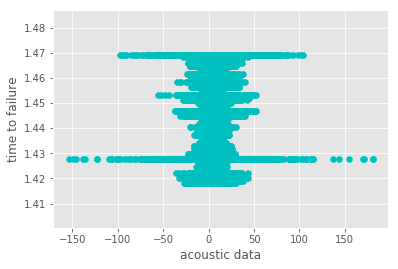

In [11]:
plt.scatter(x="acoustic_data", y="time_to_failure", data=train, c="c")
plt.xlabel("acoustic data")
plt.ylabel("time to failure")
plt.show()


Data Segmentation 

In [12]:
train.shape[0]

200000

In [13]:
rows = 5
segments = int(np.floor(train.shape[0] / rows))
segments

40000

Feature Enfineering 

In [14]:
X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min','sum','skew','kurt'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

In [15]:
%%time
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'sum'] = x.sum()
    X_train.loc[segment, 'skew'] =skew(x)
    X_train.loc[segment, 'kurt'] = kurtosis(x)

100%|██████████| 40000/40000 [02:04<00:00, 321.73it/s]


Wall time: 2min 4s


In [16]:
seg = train.iloc[0:5]
x = seg['acoustic_data'].values
x

array([12,  6,  8,  5,  8], dtype=int64)

In [17]:
train.isnull().values.any()

False

Output file

In [18]:
    submission = pd.read_csv("sample_submission.csv", index_col='seg_id')

In [19]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [20]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [21]:
X_test.head()

,ave,std,max,min,sum,skew,kurt
seg_id,,,,,,,
seg_00030f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seg_0012b5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seg_00184e,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seg_003339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seg_0042cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
%%time
for seg_id in  tqdm(X_test.index):
    seg = pd.read_csv(seg_id + '.csv')
    x = seg['acoustic_data'].values
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'sum'] = x.sum()
    X_test.loc[seg_id, 'skew'] =skew(x)
    X_test.loc[seg_id, 'kurt'] = kurtosis(x)

100%|██████████| 2624/2624 [04:25<00:00,  9.89it/s]


Wall time: 4min 25s


In [23]:
X_train.head()

,ave,std,max,min,sum,skew,kurt
0,7.8,2.400000000000000,12.0,5.0,39.0,0.670138888888889,-0.690393518518519
1,4.4,5.122499389946279,9.0,-5.0,22.0,-0.999535883062977,-0.538918426531826
2,2.2,1.939071942966532,5.0,-1.0,11.0,-0.283092214398690,-0.641240380262562
3,4.6,1.019803902718557,6.0,3.0,23.0,-0.271545417883639,-1.044378698224852
4,5.2,1.939071942966532,7.0,2.0,26.0,-0.612269207885539,-1.184472612041648


In [24]:
X_test.head()

,ave,std,max,min,sum,skew,kurt
seg_id,,,,,,,
seg_00030f,4.491780000000000,4.893673374701939,115.0,-75.0,673767.0,0.327904356179061,28.836566856132873
seg_0012b5,4.171153333333334,5.922819700375451,152.0,-140.0,625673.0,0.295704902067299,56.217040603098553
seg_00184e,4.610260000000000,6.946966920827151,248.0,-193.0,691539.0,0.428684001399945,162.112839736317284
seg_003339,4.531473333333333,4.114132889113924,85.0,-93.0,679721.0,0.061888744016031,41.240412747645323
seg_0042cc,4.128340000000000,5.797144312308719,177.0,-147.0,619251.0,0.073897611771741,79.537016314536231


In [25]:
y_train.head()

,time_to_failure
0,1.4690999788
1,1.4690999733
2,1.4690999678
3,1.4690999623
4,1.4690999568


Scaling

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [27]:
X_test_scaled = scaler.transform(X_test)

Data Partition

In [28]:
X_train_scaled_df=pd.DataFrame(X_train_scaled)

In [29]:
X_train_scaled_df.columns = [X_train.columns]

In [30]:
X_train_scaled_df.head()

,ave,std,max,min,sum,skew,kurt
0,0.617379006482444,-0.084159077406168,0.692935932725475,0.701787212402429,0.617379006482444,1.129869575924870,0.703400164980378
1,-0.091218364843802,1.409758126412185,0.127412442375785,-1.220272404308207,-0.091218364843802,-1.685839233939018,1.007987880729889
2,-0.549722546290197,-0.337084149370445,-0.626618878090467,-0.451448557623953,-0.549722546290197,-0.477641815186026,0.802237814833840
3,-0.049536166530494,-0.841514139444356,-0.438111047973904,0.317375289060302,-0.049536166530494,-0.458169510028579,-0.008396975274236
4,0.075510428409432,-0.337084149370445,-0.249603217857341,0.125169327389238,0.075510428409432,-1.032759839447668,-0.290099297683885


In [31]:
X=X_train_scaled_df
y=y_train.copy()
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [32]:
rf = RandomForestRegressor(max_depth=5, random_state=0,n_estimators=100)

rf.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [33]:
Yhat_tr=rf.predict(train_X)
Yhat_te=rf.predict(val_X)

In [34]:
from sklearn.metrics import mean_squared_error
a=mean_squared_error(Yhat_tr, train_y)
b=mean_squared_error(Yhat_te, val_y)
a

0.00022189966094614825

In [35]:
b

0.00022469152233707627

In [36]:
from sklearn.metrics import mean_absolute_error
c=mean_absolute_error(Yhat_tr, train_y)
d=mean_absolute_error(Yhat_te, val_y)
c

0.012885177923378899

In [37]:
d

0.012949007849978326

XGBOOST

In [39]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(train_X,train_y)


[23:16:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [40]:
Yhat_train_xgb=xg_reg.predict(train_X)
Yhat_test_xgb=xg_reg.predict(val_X)

In [42]:
mean_absolute_error(Yhat_test_xgb, val_y)

0.012949671633139738

In [41]:
mean_absolute_error(Yhat_train_xgb, train_y)

0.012744077194785989

In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [ ]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)